**Error]** **<span style="color:Orange">에러명</span>**: 사유

# 인물사진을 만들어 보자
-----
### 프로젝트 - 인물 모드 문제점 찾기

핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내냅니다.<br>물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다릅니다.<br>오늘 만들어볼 **목표는 핸드폰 인물사진 모드**입니다.<br>사실 핸드폰 인물 사진 모드를 정확히 따라하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내내 보겠습니다.

## 순서
> **Step1.** 인물모드 직접 해 보기<br>
**Step2.** 사진에서 문제점 찾기<br>
**Step3.** 해결 방법을 제안해 보기

**✓ 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.**
>1. 배경이 있는 셀카를 촬영합니다.(배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
>2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
>3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
>4. 피사체를 배경의 원래 위치에 합성 합니다.

오늘 사용할 패키지를 불러옵니다.<br>아래 패키지가 없다면 터미널에서 **`pip install [패키지명]`**을 사용해 필요한 패키지를 설치해 주세요.<br>cv2 패키지의 경우 아래 명령어를 사용하시면 됩니다.

> $ pip install opencv-python

**✓ 본격적인 실습 전에 인물사진 모드에서 사용되는 용어를 먼저 알아보고 가죠!**

* **아웃포커싱(out Focusing)**
    * 아웃포커싱은 한국에서만 사용하는 용어
    * 정확한 영어 표현은 얕은 **피사계 심도(shallow depth of field)** 또는 **셸로우 포커스(shallow focus)**
    

* **보케(bokeh)**
    * 일본어에서 유래된 표현
    * 영문권에서도 많이 사용하는 용어지만 그 의미가 직관적이지 못함
    * 핸드폰 제조사에서도 이것을 알고 **'인물사진(portrait)'**이라는 직관적인 용어를 만들어 냄
    

* **이미지 세그멘테이션(image segmentation)**
    * 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
    * 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정
    * 공통 특징은 물리적 의미가 없을 수도 있음(픽셀이 비슷하게 생겼다는 사실은 인식)
    * 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출
    
    * **+ 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)**
        * 이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것
        * 픽셀 값(그레이스케일(grayscale)로 변환하면 0~255의 값)을 이용해서 각 위치의 높고 낮음을 구분
        * 낮은 부분부터 서서히 '물'을 채워 나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 되는데 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됨
    
    
* **시멘틱 세그멘테이션(semantic segmentation)**
    * 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
    * 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법
    * **오늘 다룰 세그멘테이션 방법!**
    

* **인스턴스 세그멘테이션(Instance segmentation)이**
    * '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법
    * 더 나아가서 사람 개개인 별로 다른 라벨을 가지게 함
    * 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표
    * 인스턴스의 세그멘테이션 데이터셋의 id뿐만이 아닌 **클래스 라벨이 존재**해야 시맨틱 세그멘테이션으로 학습이 가능

### <span style="color:green">Step1. 인물모드 직접 해 보기</span>
---
>- 셀카를 이용해서 프로젝트를 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 **3장 이상**의 인물모드 사진을 만들어 봅시다.
>- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
> - 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다. 환상적인 사진을 만들어 보면 어떨까요?

**✓ 사용할 패키지 불러오기**

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹에서 데이터를 다운로드 받을 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

**✓ 사용할 이미지 불러오기**

In [2]:
# import os

img_path_0 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_0.png'  # 예시사진
img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_1.png'  # 인물사진
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_2.png'  # 반려동물사진

img_0 = cv2.imread(img_path_0)
img_1 = cv2.imread(img_path_1)
img_2 = cv2.imread(img_path_2)

print (img_path_0.shape)
print (img_path_1.shape)
print (img_path_2.shape)

(225, 225, 3)


로명은 본인의 컴퓨터 디렉토리에 맞게 바꾸어 주세요. 리눅스 명령어 **`pwd`** 를 사용하면 손쉽게 파일의 절대경로를 찾을 수 있습니다.

### <span style="color:green">Step2. 사진에서 문제점 찾기</span>
---
아래 사진에도 문제점이 몇가지 있었습니다.<br>예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다. ㅠㅠ<br>그 외 다른 문제들이 눈에 띄시나요?<br>아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 직접 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다.

![](https://aiffelstaticprd.blob.core.windows.net/media/images/E-14-13.max-800x600.png)

조원과 같이 찾은 문제점은 다음과 같습니다.
1. 오른쪽(촬영자 기준) 귀의 블러처리로 인하여 이어폰줄이 끊겨있다.
2. 왼쪽(촬영자 기준)어깨 윗 부분이 블러처리 되어 있다.

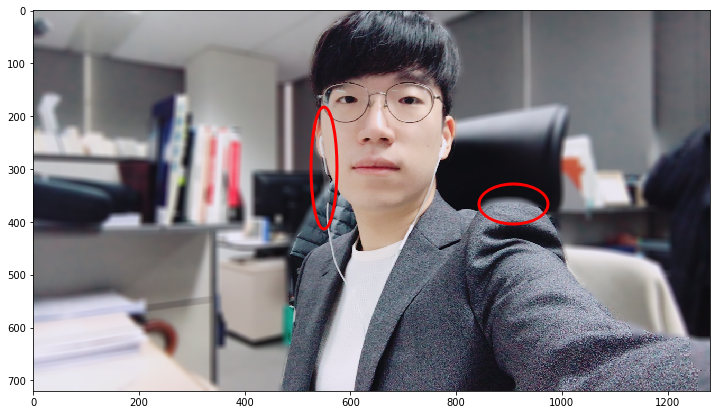

### <span style="color:green">Step3. 해결 방법을 제안해 보기</span>

엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요.<br>가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

- 세그멘테이션의 한계
- 피사계 심도 이해하기
- 3D Depth Camera 활용하기
- 깊이 영상(Depth image) 활용하기
- IR(적외선)을 활용한 사례

# <span style="color:purple">루브릭 평가 기준</span>
---
번호|평가문항|상세기준
---|---|---
1 |인물모드 사진을 성공적으로 제작하였다.|**`아웃포커싱 효과`**가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 **각각 1장 이상** 성공적으로 제작하였다.
2 |제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3 |인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 **semantic segmentation mask의 오류를 보완**할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

# <span style="color:purple">회고</span>
---